<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Read-in-the-height-and-reflectivity-fields" data-toc-modified-id="Read-in-the-height-and-reflectivity-fields-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read in the height and reflectivity fields</a></span></li><li><span><a href="#Now-go-get-the-rain-rate" data-toc-modified-id="Now-go-get-the-rain-rate-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Now go get the rain rate</a></span></li><li><span><a href="#Make-a-masked-array-of-the-reflectivity-so-that-pcolormesh-will-plot-it" data-toc-modified-id="Make-a-masked-array-of-the-reflectivity-so-that-pcolormesh-will-plot-it-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make a masked array of the reflectivity so that pcolormesh will plot it</a></span></li><li><span><a href="#Find-the-part-of-the-orbiting-that-corresponds-to-the-3-minutes-containing-the-storm" data-toc-modified-id="Find-the-part-of-the-orbiting-that-corresponds-to-the-3-minutes-containing-the-storm-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Find the part of the orbiting that corresponds to the 3 minutes containing the storm</a></span></li><li><span><a href="#convert-time-to-distance-by-using-pyproj-to-get-the-greatcircle-distance-between-shots" data-toc-modified-id="convert-time-to-distance-by-using-pyproj-to-get-the-greatcircle-distance-between-shots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>convert time to distance by using pyproj to get the greatcircle distance between shots</a></span></li><li><span><a href="#Make-the-plot-assuming-that-height-is-the-same-for-every-shot" data-toc-modified-id="Make-the-plot-assuming-that-height-is-the-same-for-every-shot-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Make the plot assuming that height is the same for every shot</a></span></li><li><span><a href="#Now-add-the-rain-rate" data-toc-modified-id="Now-add-the-rain-rate-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Now add the rain rate</a></span></li><li><span><a href="#Repeat-for-precipitatable-liquid-water-and-retrieval-uncertainty" data-toc-modified-id="Repeat-for-precipitatable-liquid-water-and-retrieval-uncertainty-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Repeat for precipitatable liquid water and retrieval uncertainty</a></span></li></ul></div>

In [23]:
import pdb

# Introduction

This notebook finds the the point at which the ECMWF tempearture=0 deg C for each
radar pulse and overlays that on the reflectivity plot to check to see whether
the bright band occurs at the freezing level

#  Read in the height and reflectivity fields

In [24]:
from importlib import reload
import numpy as np
import datetime as dt
from datetime import timezone as tz
from matplotlib import pyplot as plt
import pyproj
from numpy import ma
import a301
from a301.cloudsat import get_geo
from pathlib import Path
from pyhdf.SD import SD, SDC
#
# new functions to read vdata and sds arrays
#
from a301.cloudsat import HDFvd_read, HDFsd_read
plt.style.use('ggplot')
print(list(a301.data_dir.glob('*GEOPROF_GRANULE*hdf')))

[WindowsPath('C:/Users/Pearl/Desktop/ATSC 301/a301_code/data/2010258022504_23311_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf'), WindowsPath('C:/Users/Pearl/Desktop/ATSC 301/a301_code/data/2010259161922_23334_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf')]


In [25]:
z_file= list(a301.data_dir.glob('*GEOPROF_GRANULE*hdf'))[0]
lats,lons,date_times,prof_times,dem_elevation=get_geo(z_file)
radar_reflectivity, radar_attrs = HDFsd_read(z_file,'Radar_Reflectivity')
radar_scale = radar_attrs['factor']
radar_missing = radar_attrs['missing']
radar_height, height_attrs = HDFsd_read(z_file,'Height')
meters2km=1.e3
print(z_file)

C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\2010258022504_23311_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf


# Now go get the rain rate

mask all values 

C:\Users\Pearl\Desktop\ATSC 301\a301_code\data\2010258022504_23311_CS_2C-RAIN-PROFILE_GRANULE_P_R04_E03.hdf


C:\Users\Pearl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


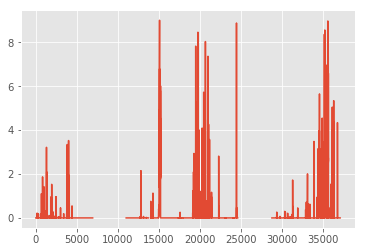

In [26]:
r_file= list(a301.data_dir.glob('*2C-RAIN-PROFILE*hdf'))[0]
rain_rate = HDFvd_read(r_file,'rain_rate',vgroup='Data Fields')
invalid = (rain_rate == -9999.)
rain_rate[invalid] = np.nan
hit = rain_rate < 0.
rain_rate[hit] = np.abs(rain_rate[hit])
plt.plot(rain_rate);
print(r_file)

# Make a masked array of the reflectivity so that pcolormesh will plot it

note that I need to find the missing data before I divide by factor=100 to
convert from int16 to float

In [27]:
hit=(radar_reflectivity == radar_missing)
radar_reflectivity=radar_reflectivity.astype(np.float)
radar_reflectivity[hit]=np.nan
zvals = radar_reflectivity/radar_scale
zvals=ma.masked_invalid(zvals)

# Find the part of the orbiting that corresponds to the 3 minutes containing the storm

You need to enter the start_hour and start_minute for the start time of your cyclone in the granule

In [28]:
first_time=date_times[0]
print(f'orbit start: {first_time}')
start_hour=4
start_minute=0
storm_start=starttime=dt.datetime(first_time.year,first_time.month,first_time.day,
                                        start_hour,start_minute,0,tzinfo=tz.utc)
#
# get 3 minutes of data from the storm_start
#
storm_stop=storm_start + dt.timedelta(minutes=3)
print(f'storm start: {storm_start}')
time_hit = np.logical_and(date_times > storm_start,date_times < storm_stop)
print(time_hit.shape)
print(rain_rate.shape)
storm_lats = lats[time_hit]
storm_lons=lons[time_hit]
storm_prof_times=prof_times[time_hit]
storm_zvals=zvals[time_hit,:]
storm_height=radar_height[time_hit,:]
storm_date_times=date_times[time_hit]
rain_rate=rain_rate[time_hit]

orbit start: 2010-09-15 02:25:11.533000+00:00
storm start: 2010-09-15 04:00:00+00:00
(37080,)
(37080, 1)


# convert time to distance by using pyproj to get the greatcircle distance between shots

In [29]:
great_circle=pyproj.Geod(ellps='WGS84')
distance=[0]
start=(storm_lons[0],storm_lats[0])
for index in np.arange(1,len(storm_lons)):
    azi12,azi21,step= great_circle.inv(storm_lons[index-1],storm_lats[index-1],
                                       storm_lons[index],storm_lats[index])
    distance.append(distance[index-1] + step)
distance=np.array(distance)/meters2km

# Make the plot assuming that height is the same for every shot

We need to customize the subplots so we can share the x axis between the radar reflectivity
and the rain_rate, and adjust the sizes to hold a colorbar

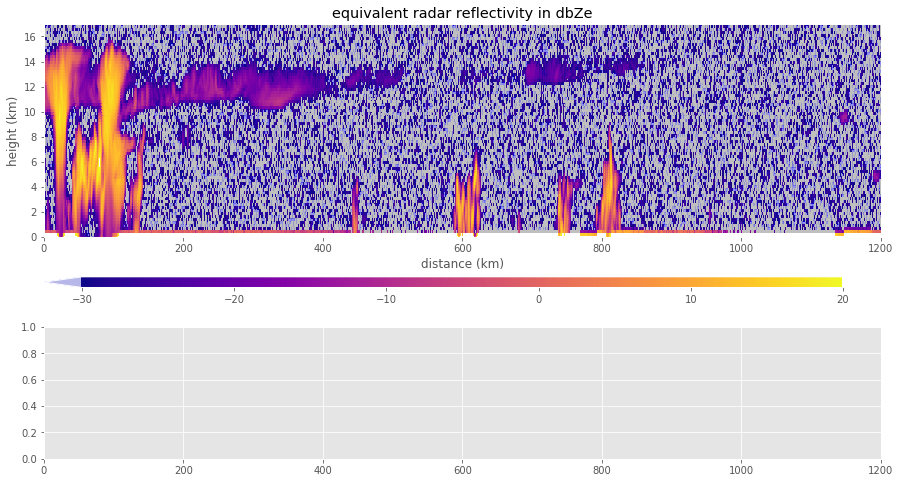

In [30]:
%matplotlib inline

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_field2(distance,height,field,fig,cmap=None,norm=None):
    """
    draw a 2 panel plot with different panel sizes.  Put the radar reflectivity
    in the top panel with a colorbar along the bottom, and pass the second
    axis back to be filled in later
    
    uses the sharex keyword to give both plots the same x axis (distance) 
    and the gridspec class to lay out the grid
    
    https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
    """
    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    if cmap is None:
        cmap=cm.inferno
    col=ax1.pcolormesh(distance,height,field,cmap=cmap,
                  norm=the_norm)
    #https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # create an axes on the bottom side of ax1. The height of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.55 inch.
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.55)
    ax1.figure.colorbar(col,extend='both',cax=cax,orientation='horizontal')
    return ax1, ax2

vmin=-30
vmax=20
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('w')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey

cloud_height_km=radar_height[0,:]/meters2km
fig = plt.figure(figsize=(15, 8)) 
ax1, ax2 = plot_field2(distance,cloud_height_km,storm_zvals.T,fig,cmap=cmap_ref,norm=the_norm)
ax1.set(ylim=[0,17],xlim=(0,1200))
ax1.set(xlabel='distance (km)',ylabel='height (km)',
       title='equivalent radar reflectivity in dbZe');


# Now add the rain rate

Use the second axis to draw the rain rate and redraw the figure

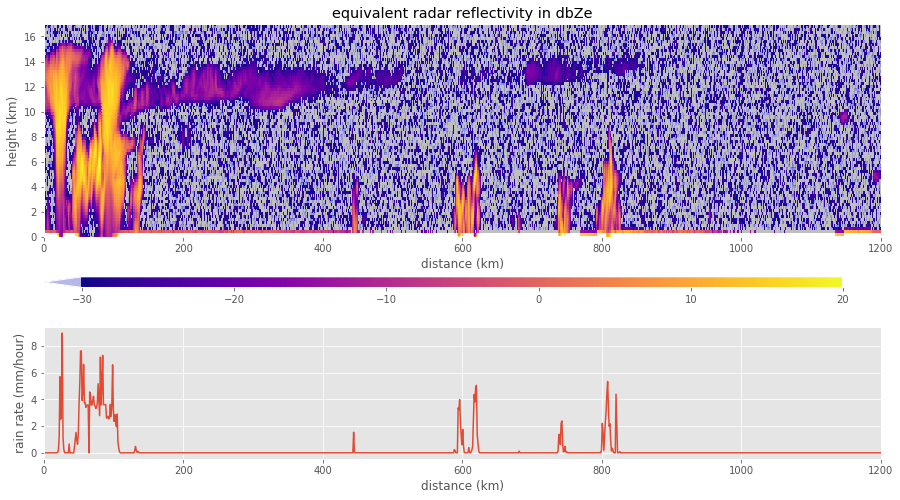

In [31]:
ax2.plot(distance,rain_rate)
ax2.set(xlabel='distance (km)',ylabel='rain rate (mm/hour)')
display(fig)

# Repeat for precipitatable liquid water and retrieval uncertainty

Make a new plot pair -- for variable information see the [dataset docs](http://www.cloudsat.cira.colostate.edu/data-products/level-2c/2c-rain-profile?term=56)

In [32]:
liquid_water, lw_attributes = HDFsd_read(r_file,'precip_liquid_water')
lw_attributes

{'factor': 1000.0,
 'offset': 0.0,
 'long_name': 'Liquid precipitation water content',
 'units': 'g/m3',
 'valid_range': [0, 10000],
 'missing': 28008}

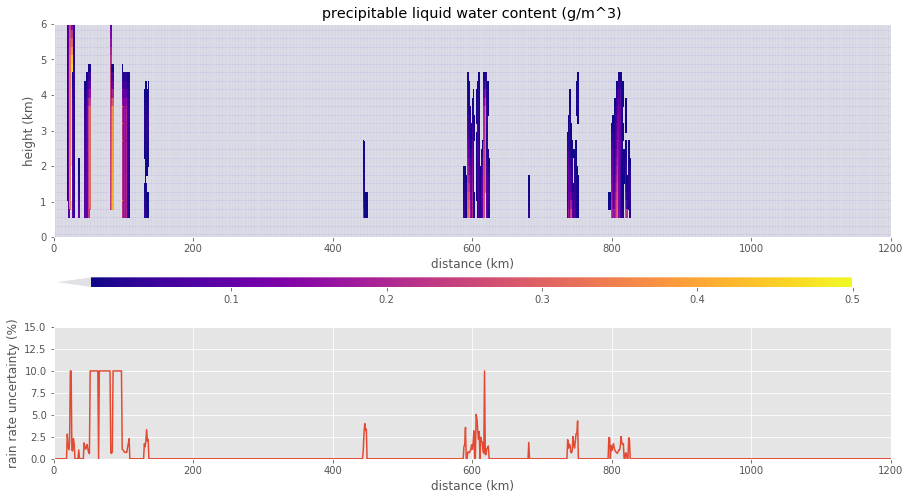

In [33]:
precip_uncertainty = HDFvd_read(r_file,'rain_rate_uncertainty',vgroup='Data Fields')
storm_liquid=liquid_water[time_hit,:]/lw_attributes['factor']
precip_uncert=precip_uncertainty[time_hit]

vmin=0.01
vmax=0.5
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('w')
cmap_ref.set_under('b',alpha=0.02)
cmap_ref.set_bad('0.75') #75% grey

fig = plt.figure(figsize=(15, 8)) 
ax1, ax2 = plot_field2(distance,cloud_height_km,storm_liquid.T,fig,cmap=cmap_ref,norm=the_norm)
ax1.set(ylim=[0,6],xlim=(0,1200))
ax1.set(xlabel='distance (km)',ylabel='height (km)',
       title='precipitable liquid water content (g/m^3)')
ax2.plot(distance,precip_uncert)
ax2.set(ylim=[0,15],xlabel='distance (km)',ylabel='rain rate uncertainty (%)');

In [34]:
lw_attributes

{'factor': 1000.0,
 'offset': 0.0,
 'long_name': 'Liquid precipitation water content',
 'units': 'g/m3',
 'valid_range': [0, 10000],
 'missing': 28008}